### Name: Fellipe Paes Ferreira
#### Module: Applied Machine Learning
#### Project 1

importing libraries

In [120]:
import sys
#!{sys.executable} -m pip install wordcloud 

#!{sys.executable} -m conda install -c conda-forge wordcloud



In [2]:
 #pip install tabulate

In [101]:
from builtins import type

import matplotlib
import numpy as np
import pandas as pd
import glob
import re
#import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator
from sklearn import svm
from sklearn import metrics
from sklearn.utils import shuffle
import joblib
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from wordcloud import WordCloud

from datetime import datetime
from IPython.display import display
from tabulate import tabulate

## 1 - Indroduction

The primary goal of the assignment is to create a supervised classification pipeline to classify emails as spam or non-spam from the training data. The dataset provided is subdivided in two folders for each category "SPAM" and "HAM" (not spam). For each folder contains the emails and each email is in one file.




## 2 - Preprocessing

### 2.1 - Loading files
The next step is read the files and create the structure to perform the classification. Basically the structure uses a dictionary with column for email and other colum with type of email, spam or ham. In this case, for spam were defined the label value equal to 1 and for ham equal to 0.

In [2]:
def loadFiles(dir):

    content = list()
    files = glob.glob(dir)
    for name in files:
            with open(name, encoding="utf8", errors='ignore') as f:
                values = f.read()
                values = values.splitlines()
                content.append(values)
    return content

In [3]:
def create_structure():
    dir_spam = "enron1/spam/*.txt"
    dir_ham = "enron1/ham/*.txt"

    contentSpam = loadFiles(dir_spam)
    contentHam = loadFiles(dir_ham)

    #print(content)
    structureSpam = pd.DataFrame(zip(contentSpam), columns=["emails"])
    structureSpam["target"] = 1

    structureHam = pd.DataFrame(zip(contentHam), columns=["emails"])
    structureHam["target"] = 0

    return structureHam, structureSpam

In [4]:
ham, spam = create_structure()

In [5]:
print(ham.head())

                                              emails  target
0  [Subject: ena sales on hpl, just to update you...       0
1  [Subject: 98 - 6736 & 98 - 9638 for 1997 ( ua ...       0
2  [Subject: hpl nominations for december 28 , 19...       0
3  [Subject: revised nom - kcs resources, daren ,...       0
4  [Subject: new production - sitara deals needed...       0


In [6]:
print(spam.head())

                                              emails  target
0  [Subject: what up , , your cam babe, what are ...       1
1  [Subject: want to make more money ?, order con...       1
2  [Subject: food for thoughts, [, join now - tak...       1
3  [Subject: miningnews . net newsletter - tuesda...       1
4  [Subject: your pharmacy ta, would you want che...       1


### 2.2 - Merging ham and spam

To perform the classification is required that all emails are organised in the same object. 

In [7]:
def merge_ham_spam(structureHam, structureSpam):
    emails = structureSpam.append(structureHam)

    #remove the sublist
    emails['emails'] = [" ".join(email) for email in emails['emails'].values]

    return emails

In [8]:
emails = merge_ham_spam(ham, spam)

print(emails)

                                                 emails  target
0     Subject: what up , , your cam babe what are yo...       1
1     Subject: want to make more money ? order confi...       1
2     Subject: food for thoughts [ join now - take a...       1
3     Subject: miningnews . net newsletter - tuesday...       1
4     Subject: your pharmacy ta would you want cheap...       1
...                                                 ...     ...
3667  Subject: class confirmation - stacey neuweiler...       0
3668  Subject: hpl noms for april 27 , 2001 ( see at...       0
3669  Subject: beaumont methanol - meter 1428 - octo...       0
3670  Subject: re : free agents send me a request of...       0
3671  Subject: associate & analyst mid - year 2001 p...       0

[5172 rows x 2 columns]


In [9]:
def graph_categories(emails):
    sizeHam = len(emails[emails["target"] == 0])
    sizeSpam = len(emails[emails["target"] == 1])

    print("ham ",sizeHam)
    print("spam ", sizeSpam)

    df = pd.DataFrame({'lab':['Ham', 'Spam'], 'val':[sizeHam, sizeSpam]})
    df.plot.bar(x='lab', y='val', rot=0)

    plt.title("Quantity emails by category")
    plt.xlabel("Category")
    plt.ylabel("Quantity")
    plt.show()

ham  3672
spam  1500


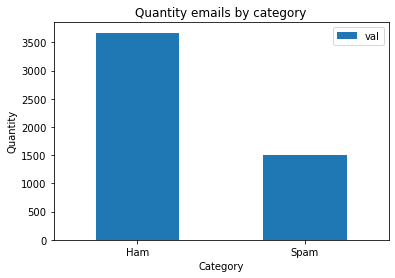

In [10]:
graph_categories(emails)

### 2.3 - Cleaning data

This step consist in cleaning the dataset in order to perform the trainment. This process will remove capital letters and change to lower case, removing the ponctuation, remove white spaces between the words and at the end. Finally will remove the stoping words. Stopwords are common words which provide little to no value to the meaning of the text. ‘We’, ‘are’ and ‘the’ are examples of stopwords. 



In [11]:
# The NLTK and Scikit Learn libraries has pre-defined stop words. In order to use all these words
def getStopWords():
    #nltk.download()
    #nltk.download("stopwords")

    nltk_stop_words = stopwords.words('english')
    sklearn_stop_words = ENGLISH_STOP_WORDS

    my_words = {"subject", "cc", "to"}

    print(type(nltk_stop_words))
    print(type(sklearn_stop_words))

    all_stopwords = set()

    #include stop words from nltk library
    all_stopwords = set(nltk_stop_words)

    # include stop words from scikit learn library
    all_stopwords.update(set(sklearn_stop_words))

    #include words that I notice
    all_stopwords.update(my_words)

    return all_stopwords


In [12]:
def cleanData(data):
    print("Cleaning data....")

    words_list = getStopWords()

    data['emails'] = (data['emails']
                      .str.lower()  # lowercase
                      .str.replace(r'[^\w\s]+', '')  # rem punctuation
                      .apply(lambda x: ' '.join([item for item in x.split() if item not in words_list]))
                      .str.strip()  # rem trailing whitespaces
                      .str.split() # split by whitespaces
                      )


In [13]:
cleanData(emails)


Cleaning data....
<class 'list'>
<class 'frozenset'>


The emails now is cleaned. We can the word subject is not present in the emails

In [14]:
print(emails)

                                                 emails  target
0     [cam, babe, looking, looking, companion, frien...       1
1     [want, make, money, order, confirmation, order...       1
2     [food, thoughts, join, free, tour, click, remo...       1
3     [miningnews, net, newsletter, tuesday, january...       1
4     [pharmacy, ta, want, cheap, perscriptions, htt...       1
...                                                 ...     ...
3667  [class, confirmation, stacey, neuweiler, stace...       0
3668  [hpl, noms, april, 27, 2001, attached, file, h...       0
3669  [beaumont, methanol, meter, 1428, october, 200...       0
3670  [free, agents, send, request, want, make, tran...       0
3671  [associate, analyst, mid, year, 2001, prc, pro...       0

[5172 rows x 2 columns]


### 2.4 - Feature extraction 

This project uses two libraries to handling the machine learning model. The NLTK and Scikit Learn libraries provide a list of stoping words to use in the ML projects. The stop word list of the libraries was combined in one unique list of words to be more complete the number of words removed. In addition, new words was included to that list. This project uses emails dataset and there are common words used in emails. Resulting in more complete list of stop words.

This is the list of personalised words that I have included to be removed.
my_words = {"subject", "cc", "to"}

As this process is part of cleaning data (the cleaning method uses the stopwords method), is alredy performed in that email. The list of words to be removed is listed below.

In [15]:
print(getStopWords())


<class 'list'>
<class 'frozenset'>
{'nobody', 'more', 'whenever', 'next', 'don', 'to', 'any', 'call', 'she', 'them', 'do', 'wouldn', 'her', 'whoever', 'nowhere', 'rather', 'it', 'sixty', 'becoming', 'beside', 'mightn', 'therefore', "didn't", 'fifty', 'less', 'front', 'this', 'our', "hadn't", 'side', 'sometime', "you'll", "you're", 'toward', 'isn', 'its', 'what', 'an', 'who', 'my', 'further', "isn't", 'behind', 'forty', "shan't", 'how', 'whereafter', "haven't", 'few', 'twenty', 'both', 'bottom', 'otherwise', 'anyway', 'back', "you'd", 'hereafter', 'then', 'they', 'give', 'two', 'thick', 'd', 'off', 'towards', 's', 'i', 'via', 'cc', 'once', 'during', 'his', 'whereas', 'as', 'six', "needn't", 'be', 'thence', 'others', 'take', 'would', 'we', 'when', 'too', 'herself', 'just', 'here', 'mostly', 'ourselves', "weren't", 'indeed', 'nevertheless', 'enough', 'nothing', 'at', 'find', 'by', 'perhaps', 'ten', 'with', 'hers', 'across', 'whereby', 'eleven', 'co', 'wasn', 'somehow', "it's", 'already', 

### 2.5 - Remove empty emails

After the process of cleaning data and remove stop words. It is possible that some emails become empty by removing all the words in the content.  

In [16]:
def remove_empty_emails(emails):

    #empty = emails[emails['emails'].astype(bool)]

    empty = emails[emails['emails'].apply(len) == 0]

    print(f"Total empty emails: {len(empty)} ")
    print(empty.head())

    emails =  emails[emails['emails'].apply(len) != 0]

    return emails



In [17]:
emails = remove_empty_emails(emails)

Total empty emails: 17 
    emails  target
13      []       1
161     []       1
282     []       1
337     []       1
401     []       1


The development of the model is an iteractive process. I cound see while improving the cleaning method, including more features and words to be removed. The performance of the model increased, specialy when I included the extra words related to email context. That means, removing words that do not contribute for the model can improve their performance.

After cleaning emails, the amount of emails is reduced. 

ham  3672
spam  1483


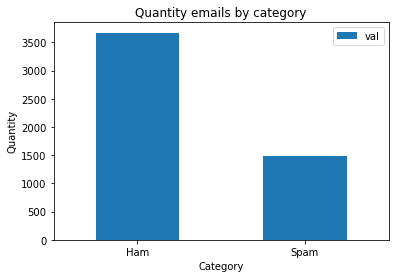

In [18]:
graph_categories(emails)

### 2.6 Shuffling emails

The shuffling operation is very important to perform the ML classifier. When the dataset is well shuffled, it avoid any element of bias/patterns in the split datasets before training the ML model. There are some advantages for shuffling the data: avoid bias during the training, improve the ML model quality, improve the predictive performance.

In [19]:
def shuffle_emails(emails):
    return  sklearn.utils.shuffle(emails)


In [20]:
print("Before shuffle:")
print(emails.head())

emails = shuffle_emails(emails)



Before shuffle:
                                              emails  target
0  [cam, babe, looking, looking, companion, frien...       1
1  [want, make, money, order, confirmation, order...       1
2  [food, thoughts, join, free, tour, click, remo...       1
3  [miningnews, net, newsletter, tuesday, january...       1
4  [pharmacy, ta, want, cheap, perscriptions, htt...       1


In [21]:
print("After shuffle:")
print(emails.head())

After shuffle:
                                                 emails  target
1705  [jan, feb, midcon, invoices, daren, informatio...       0
1142  [enron, hpl, actuals, sept, 5, 2000, teco, tap...       0
2152  [enron, hpl, actuals, july, 19, 2000, teco, ta...       0
1613  [hpl, nom, january, 27, 2001, attached, file, ...       0
455   [vlagra, 2, 60, discount, drugs, save, 80, ord...       1


### 2.7 - Training and test splits

The dataset was splitted in 70% for training and 30% for test. The library Scikit Learn provides this method for this task.

In [22]:
def splitData(emails):

    emails['emails'] = [" ".join(email) for email in emails['emails'].values]
    
    x_train, x_test, y_train, y_test = train_test_split(emails["emails"], emails["target"], test_size=0.3)

    return x_train, x_test, y_train, y_test


In [23]:
x_train, x_test, y_train, y_test = splitData(emails)

In [24]:
print(len(x_train))

3608


In [25]:
print(len(x_test))

1547


## 3 - Exploratory data analysis

After the cleaning process and prepare the dataset to be trained. Is is time to understand the behaviour of the values and get some insights into the kinds of features be useful for classification.   

In [69]:
def getHamEmails(emails):
    return emails[emails["target"] == 0]

def getSpamEmails(emails):
    return emails[emails["target"] == 1]

def getTarget(value):
    if (value == 1):
        return "SPAM"
    else:
        return "HAM"

### 3.1 - Top-20 most frenquently used words

In order to count the frequency of words present in the dataset. The Scikit Learn library provided methods for this task, the CountVectorizer. Scikit-learn’s CountVectorizer is used to convert a collection of text documents to a vector of term/token counts. It also enables the pre-processing of text data prior to generating the vector representation. This functionality makes it a highly flexible feature representation module for text. Basically this methods count the frequency of each words to be used in machine learning algorithms.

In [91]:
def get_top_n_words(emails, n=None, title=""):
    #corpus = [" ".join(email) for email in emails['emails'].values]
    corpus = emails['emails'].values
    
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    #sort by value
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    wf = words_freq[:n]
    print(wf)

    pd.DataFrame(wf, columns=['words', 'freq']).set_index('words').plot(kind='barh',figsize=(20,10) )
    plt.title(title)
    plt.xlabel("Quantity emails")
    plt.ylabel("Words")
    plt.show()


[('ect', 13897), ('hou', 7281), ('enron', 6555), ('2000', 4308), ('gas', 2861), ('deal', 2789), ('com', 2717), ('meter', 2459), ('pm', 2325), ('hpl', 2318), ('2001', 2024), ('daren', 1901), ('000', 1880), ('00', 1819), ('10', 1815), ('thanks', 1813), ('01', 1723), ('corp', 1710), ('know', 1438), ('mmbtu', 1349)]


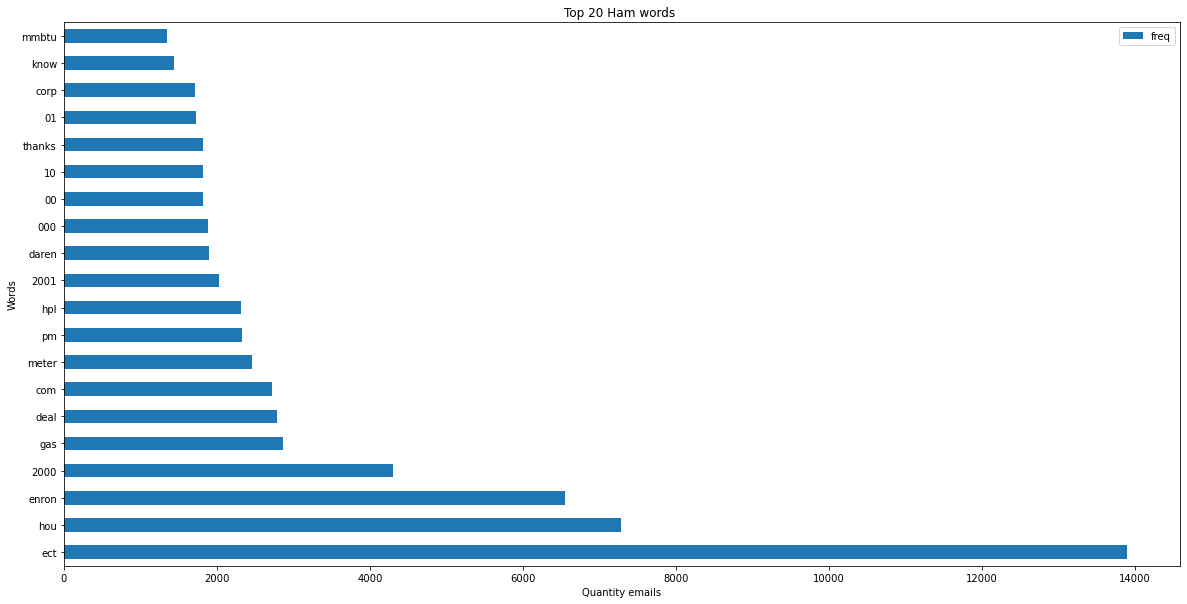

In [92]:
get_top_n_words(getHamEmails(emails), 20, "Top 20 Ham words ")
#print(getHamEmails(emails))

[('com', 993), ('http', 983), ('company', 731), ('www', 587), ('00', 585), ('information', 520), ('font', 515), ('td', 504), ('statements', 476), ('email', 475), ('price', 471), ('new', 434), ('nbsp', 418), ('height', 362), ('time', 361), ('99', 321), ('free', 314), ('pills', 311), ('size', 306), ('width', 306)]


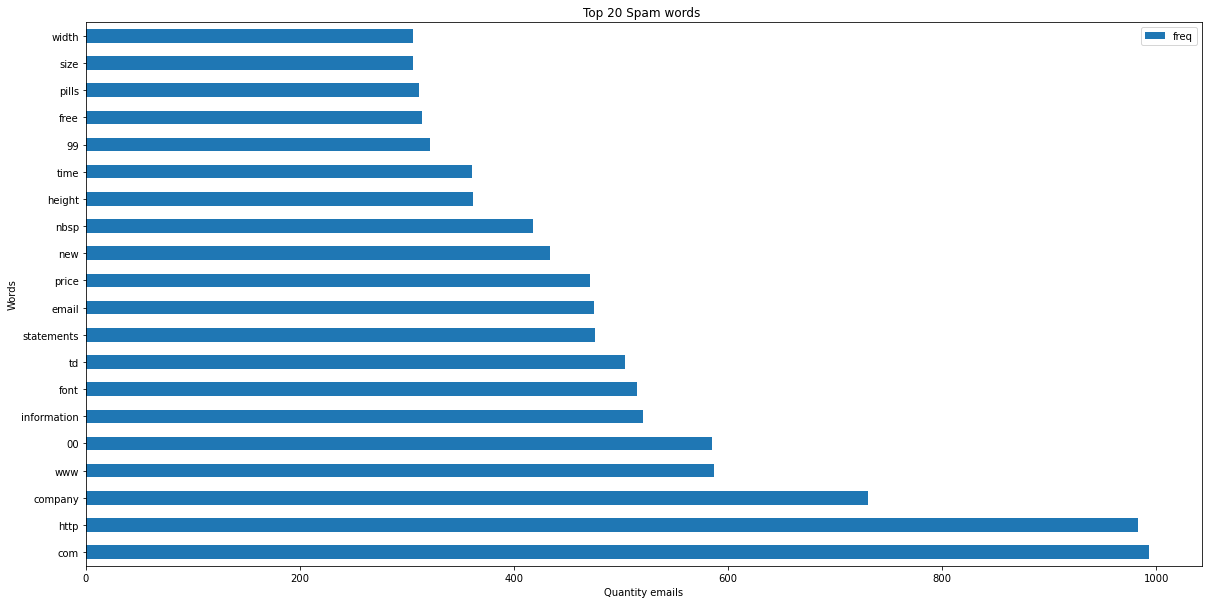

In [93]:
get_top_n_words(getSpamEmails(emails), 20, "Top 20 Spam words ")

### 3.2 - Word cloud

This is a nice graph that we can visualize the words that most appear in the dataset. We can see through of theses graphs that some words with bigger sizer appear most frequently in the dataset.

In [85]:
def create_word_cloud(emails):

    #corpus = [" ".join(email) for email in emails['emails'].values]
    corpus = emails['emails'].values
    
    words = " ".join(words for words in corpus)
    #words = words.split(" ")

    wordcloud = WordCloud(width=1600, height=800,  background_color="white").generate(str(corpus))
    plt.figure(figsize=(20,10), facecolor='k')
    plt.axis("off")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.tight_layout(pad=0)
    plt.show()

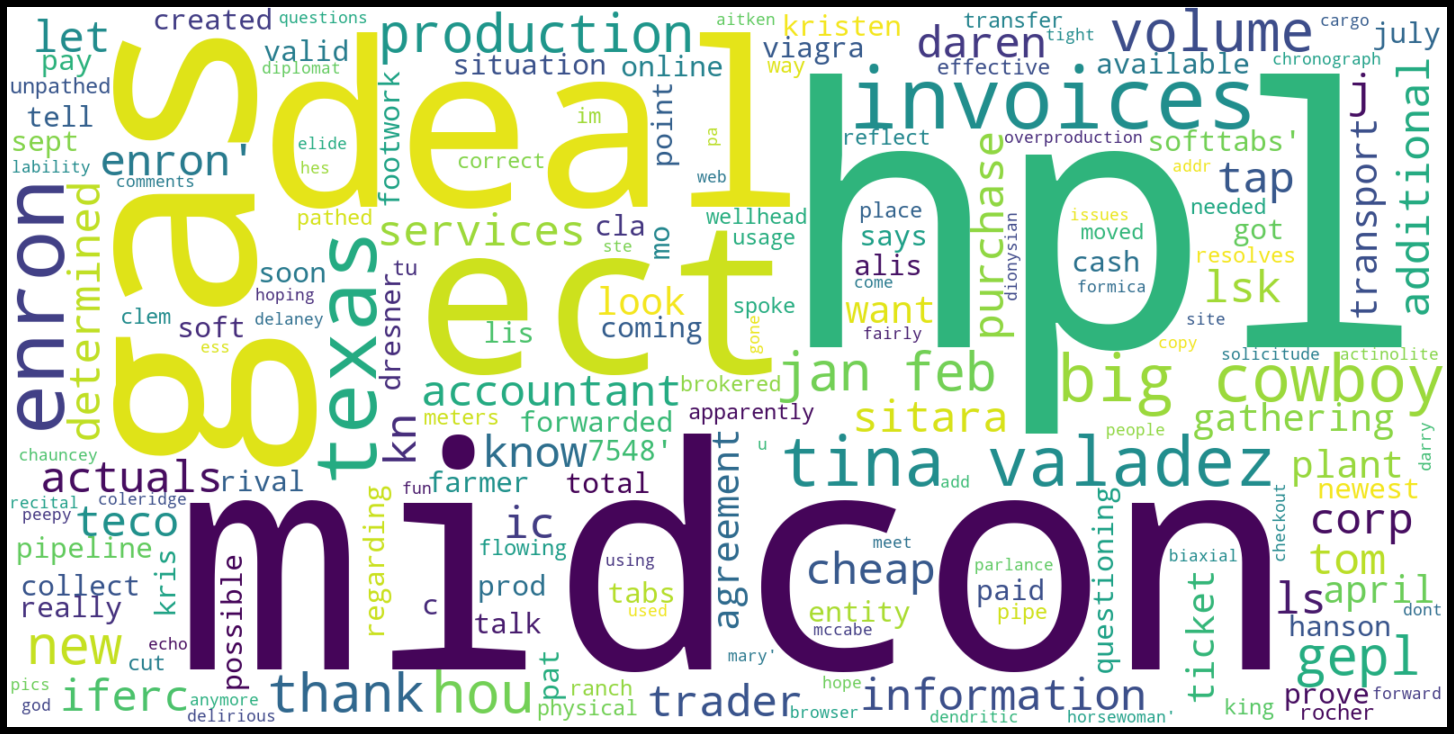

In [86]:
create_word_cloud(emails)

### 3.3 - Are spam emails shorter or longer compared to ham emails

To find this answer I calculated the average of length of the emails messages. We can see the Spam messages are bigger than ham emails.

In [34]:
def emails_message_lengh(emails):
    ham = emails[emails["target"] == 0]
    spam = emails[emails["target"] == 1]

    meanHam = ham["emails"].apply(len).mean()
    meanSpam = spam["emails"].apply(len).mean()

    df = pd.DataFrame({'lab':['Ham', 'Spam'], 'val':[meanHam, meanSpam]})
    df.plot.bar(x='lab', y='val', rot=0)

    plt.title("Average size of emails by category")
    plt.xlabel("Category")
    plt.ylabel("Average")
    plt.show()


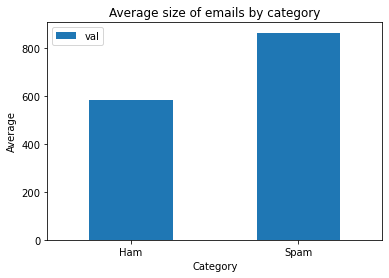

In [35]:
emails_message_lengh(emails)

## 4 - Supervised classification

Now the supervised classification algorithms will be applied on the dataset. Using the training and test set previous splited, for each algorithm will perform the traning using the training set and then with the model trained will be tested with the test set. After that performance metrics will be analised to investigate which classifier perform better.

I considered the following supervise algorithms:
* Logistic Regression
* SVM linear
* Nearest Neighbors
* Naive Bayes
* Decision Tree
* Neural Network

### 4.1 - Training process

This training step uses the TF-IDF implementation by Scikit-Learn library.  TF-IDF stands for Term Frequency — Inverse Document Frequency and is a statistic that aims to better define how important a word is for a document, while also taking into account the relation to other documents from the same corpus.

This is performed by looking at how many times a word appears into a document while also paying attention to how many times the same word appears in other documents in the corpus.

The idea of TF-IDF is:
* a word that frequently appears in a document has more relevancy for that document, meaning that there is higher probability that the document is about or in relation to that specific word

* a word that frequently appears in more documents may prevent us from finding the right document in a collection; the word is relevant either for all documents or for none.

So then TF-IDF is a score which is applied to every word in every document in our dataset. And for every word, the TF-IDF value increases with every appearance of the word in a document, but is gradually decreased with every appearance in other documents. 

To perform the TF-IDF Vectorizer and the classifier. I created a Scikit-Learn pipeline to execute the vectorizer and the classifier together. 

The Scikit-Learn implements all the ML algorithms using an amazing software design, every classifier implements methods with the same signature, such as fit(), predict(), score() and also specific methods for each classifier, becoming easier to extend and develop our own projects. 

For this project, I have created a list with all the classifiers initialized. The method executeWithPipeline receives each classifier from that list and the splited datasets. With theses parameters perform the training and test. At the end return the performance results.

### 4.2 Evaluation 
 
For each classifier we can see the performance and metric measures: training accuracy, testing accuracy, confusion matrix of the test set, slapsed time for the training and classification metrics. (https://scikit-learn.org/stable/modules/model_evaluation.html) 


In [113]:
def execute(x_train, x_test, y_train, y_test):

    #model = executeLogisticRegression(x_train, x_test, y_train, y_test)
    #executeSVM(x_train, x_test, y_train, y_test)
    #executeKNN(x_train, x_test, y_train, y_test)

    # executeLRWithPipeline(x_train, x_test, y_train, y_test)
    df_result = pd.DataFrame(columns=["classifier_name", 'classifier_pipeline','score_training','score_test','time'])

    names = ["Logistic Regression",
             "Support Vector Classification",
             "Nearest Neighbors",
             "Naive Bayes",
             "Decision Tree Classifier",
             "Neural Network",
             "Neural Network - Low Iteration" ]

    classifiers = [LogisticRegression(),
                   svm.SVC(kernel='linear'),
                   KNeighborsClassifier(n_neighbors=3),
                   MultinomialNB(),
                   DecisionTreeClassifier(max_depth=5),
                   MLPClassifier(alpha=1, max_iter=1000),
                   MLPClassifier(alpha=1, max_iter=100)]

    for name, classifier in zip(names, classifiers):
        clf_pipeline, score_training, score_test, time_elapsed = executeWithPipeline(x_train, x_test, y_train, y_test, classifier, name)

        new_row = {"classifier_name": name, 'classifier_pipeline': clf_pipeline ,'score_training': score_training, "score_test": score_test, 'time': time_elapsed}
        df_result = df_result.append(new_row, ignore_index=True)

    print(df_result)
    #display( df_result)
 
    #jupyter render pandras DF automatically
    #print(tabulate(df_result, headers='keys', tablefmt='grid'))
    df_result

    
    logReg = LogisticRegression()
    name_algorithm = "Logistic Regression"
    #executeWithPipeline(x_train, x_test, y_train, y_test, logReg, name_algorithm)

    svclassifier = svm.SVC(kernel='linear')
    #executeWithPipeline(x_train, x_test, y_train, y_test, svclassifier, name_algorithm)

    knn = KNeighborsClassifier(n_neighbors=3)
    #executeWithPipeline(x_train, x_test, y_train, y_test, knn, name_algorithm)

    mNaiveBayes = MultinomialNB()
    #executeWithPipeline(x_train, x_test, y_train, y_test, mNaiveBayes, name_algorithm)

    decisionTree = DecisionTreeClassifier(max_depth=5)
    name_algorithm = "Decision Tree Classifier"
    #executeWithPipeline(x_train, x_test, y_train, y_test, decisionTree, name_algorithm)

    nnMLP = MLPClassifier(alpha=1, max_iter=1000)
    name_algorithm = "Neural Network - MLP"
    #executeWithPipeline(x_train, x_test, y_train, y_test, nnMLP, name_algorithm)

    return df_result

In [114]:
def executeWithPipeline(x_train, x_test, y_train, y_test, algorithm, name_algorithm):
    print(f"-------------- Executing ML Algorithm: {name_algorithm} --------------")

    start_time = datetime.now()

    clf_pipeline = Pipeline([
        ('tfidf_vectorizer', TfidfVectorizer()),
        ('classifier', algorithm)])

    clf_pipeline.fit(x_train, y_train)
    predictions = clf_pipeline.predict(x_train)
    score = accuracy_score(y_train, predictions)
    score_training = score * 100

    print(f"Training accuracy: {score_training:.2f}%")

    predictions_test = clf_pipeline.predict(x_test)
    score = accuracy_score(y_test, predictions_test)
    score_test = score * 100
    print(f"Testing accuracy: {score_test:.2f}%")
    print()


    y_true = pd.Series(y_test, name='Real')
    y_pred = pd.Series(predictions_test, name='Predicted')

    y_true = y_true.reset_index(drop=True)
    y_pred = y_pred.reset_index(drop=True)

    print("Confusion matrix of test set (Pandas Library):" )
    cm = pd.crosstab(y_true, y_pred)
    print(cm)

    print("Confusion matrix of test set (Scikit-Learn): ")
    cm2 = confusion_matrix(y_true, y_pred)
    print(cm2)

    print("classification metrics: ")
    print(classification_report(y_true, y_pred, target_names=['HAM', 'SPAM']))

    #evaluateNewEmail(clf_pipeline)

    time_elapsed = datetime.now() - start_time

    return clf_pipeline, score_training, score_test, time_elapsed



In [115]:
df_result = execute(x_train, x_test, y_train, y_test)


-------------- Executing ML Algorithm: Logistic Regression --------------
Training accuracy: 99.56%
Testing accuracy: 98.90%

Confusion matrix of test set (Pandas Library):
Predicted     0    1
Real                
0          1105   13
1             4  425
Confusion matrix of test set (Scikit-Learn): 
[[1105   13]
 [   4  425]]
classification metrics: 
              precision    recall  f1-score   support

         HAM       1.00      0.99      0.99      1118
        SPAM       0.97      0.99      0.98       429

    accuracy                           0.99      1547
   macro avg       0.98      0.99      0.99      1547
weighted avg       0.99      0.99      0.99      1547

-------------- Executing ML Algorithm: Support Vector Classification --------------
Training accuracy: 99.94%
Testing accuracy: 98.64%

Confusion matrix of test set (Pandas Library):
Predicted     0    1
Real                
0          1104   14
1             7  422
Confusion matrix of test set (Scikit-Learn): 
[[110

/Users/fellipeferreira/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Training accuracy: 99.09%
Testing accuracy: 98.32%

Confusion matrix of test set (Pandas Library):
Predicted     0    1
Real                
0          1105   13
1            13  416
Confusion matrix of test set (Scikit-Learn): 
[[1105   13]
 [  13  416]]
classification metrics: 
              precision    recall  f1-score   support

         HAM       0.99      0.99      0.99      1118
        SPAM       0.97      0.97      0.97       429

    accuracy                           0.98      1547
   macro avg       0.98      0.98      0.98      1547
weighted avg       0.98      0.98      0.98      1547

                  classifier_name  \
0             Logistic Regression   
1   Support Vector Classification   
2               Nearest Neighbors   
3                     Naive Bayes   
4        Decision Tree Classifier   
5                  Neural Network   
6  Neural Network - Low Iteration   

                                 classifier_pipeline  score_training  \
0          (TfidfVector

In [116]:
df_result


,classifier_name,classifier_pipeline,score_training,score_test,time
0,Logistic Regression,"(TfidfVectorizer(), LogisticRegression())",99.556541,98.901099,00:00:01.681300
1,Support Vector Classification,"(TfidfVectorizer(), SVC(kernel='linear'))",99.944568,98.642534,00:00:06.112859
2,Nearest Neighbors,"(TfidfVectorizer(), KNeighborsClassifier(n_nei...",99.085366,96.638655,00:00:01.669127
3,Naive Bayes,"(TfidfVectorizer(), MultinomialNB())",97.283814,92.954105,00:00:00.728481
4,Decision Tree Classifier,"(TfidfVectorizer(), DecisionTreeClassifier(max...",83.980044,82.805430,00:00:00.803318
5,Neural Network,"(TfidfVectorizer(), MLPClassifier(alpha=1, max...",99.196231,98.190045,00:02:21.408237
6,Neural Network - Low Iteration,"(TfidfVectorizer(), MLPClassifier(alpha=1, max...",99.085366,98.319328,00:03:05.096455


### 4.3 Results

After the execution of each classifier the parameters of performance are collected and condenced into a pandas Data Frame, to be analised. 

This graph shows the test accuracy of each classifier and we can see which classifer with the best performance and the worst. The neural network takes long time to be executed, almost 3 minutes. I created other instance of Neural Network with lower number of iterations but not converge and takes more time to execute.

In [39]:
def graph_performance(df_result):
    #df_result.plot.bar(x="classifier_name",y="score_test")


    graph = sns.catplot(x="classifier_name", y="score_test", data=df_result, kind="bar")
    graph.set_xticklabels( rotation=40, ha="right")
    graph.set(ylim=(80, 100))
    plt.tight_layout()
    plt.show()

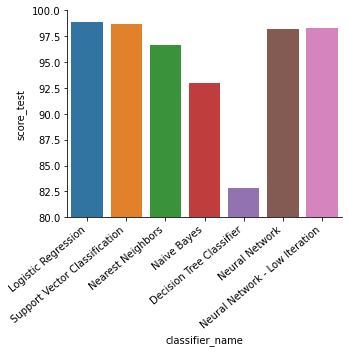

In [121]:
graph_performance(df_result)

### 4.4 Test with unseen emails

This task I have collected from euron dataset number 2, one unseen email of each label. The pipeline of Naive Bayes was used to this task. I choose two emails with a short text with enough information and with relavant keywords for analysis, just for demonstration.

In [80]:
def evaluateNewEmail(model):
    print("----------------- Evaluating new email -----------------")

    text_list = list()
    text_spam = """
    Subject: more site sales
do you take credit cards ?
if you do you will make more money . easy set up . . no credit checks - 100 % approval . . . .
make more money now !
try now
remove info is found on web site 
"""


    text_ham = """
    Subject: japan candidate
    vince ,
i spoke with whalley at the sa offsite and he mentioned that had ( or knew of )
a person that could bring some talent to the evaluation of an enron merchant
business in japan . i am in sydney today , but will be in tokyo next week . i
would like to speak more about this . what time might you be available ? my
japan mobile number is 81 90 4073 6761 .
regards ,
joe
"""


    print("Predict unseen spam text: ")
    prediction = model.predict([text_spam])
    print("result: ", getTarget(prediction))

    print("Predict unseen ham text: ")
    prediction = model.predict([text_ham])
    print("result: ", getTarget(prediction))


In [81]:
df_condition = df_result.loc[df_result['classifier_name'] == 'Naive Bayes']
classifier = df_condition["classifier_pipeline"].values[0]


In [82]:
evaluateNewEmail(classifier)

----------------- Evaluating new email -----------------
Predict unseen spam text: 
result:  SPAM
Predict unseen ham text: 
result:  HAM


## 5.0 Running the code

This code was developed using PyCharm, because I am used to this IDE and also the debug funcionalty that is very helpful when developing a project. 
All the code in this Jupyter file can be executed in sequency from the first line to the last line. 